# Credit Card Customers_Feature Engineering and Scaling

### Overview

In the previous notebook (Cleaning, EDA, and Visualization), we explored data analysis, and created some visualizations to see the relationships between variables. 

In this notebook, I will figure out which methods of feature engineering, feature selection, sample balancing technique are best for this dataset. 

### Import Packages

In [73]:
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard'

In [2]:
# set up path for data
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard/Data/')

In [131]:
# Data pre-processing 
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
)
from sklearn.model_selection import train_test_split


# Modelling 
from sklearn.metrics import (
    roc_auc_score,
    plot_roc_curve,
    precision_recall_curve,
    plot_precision_recall_curve,
    auc,
    precision_score, 
    accuracy_score, 
    recall_score,
    classification_report, 
    confusion_matrix
)

from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier)

import xgboost as xgb

# for feature engineering
from feature_engine import encoding as ce

# Evaluation & CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score


# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


### Load data

In [8]:
df = pd.read_csv(path/'BankChurners.csv')

In [9]:
# drop unuseful columns 
df.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

In [10]:
df.shape

(10127, 20)

In [11]:
df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [13]:
# create lists for categorical and numerical variables
cat_vars = [var for var in df.columns if df[var].dtype=='O' and var != 'Attrition_Flag']
num_vars = [var for var in df.columns if df[var].dtype!='O']

print('The number of categorical variables: {}'.format(len(cat_vars)))
print('The number of numerical vairables: {}'.format(len(num_vars)))

The number of categorical variables: 5
The number of numerical vairables: 14


## Feature Engineering

### Separate train and test set

Before we perform feature engineering techniques, we need to separate train and test set, because some methods should learn parameters from ONLY train to avoid over-fitting. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Attrition_Flag'], axis=1), #predictors
    df['Attrition_Flag'], # target
    test_size=0.2, # the percentage of test size
    random_state=0, # for reproducibility
)

X_train.shape, X_test.shape    

((8101, 19), (2026, 19))

### Create function for evaluating model performances

We would like to create function to evaluate model performances and this would help compare perfoamcnes. 

I will use Random Forests for comparison and ROC-AUC score.

In [40]:
def run_RFs(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=40, random_state=42, max_depth=3)
    rf.fit(X_train, y_train)
    
    print("Train set")
    train_pred = rf.predict_proba(X_train)
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_train, train_pred[:,1])))
    
    print("Test set")
    test_pred = rf.predict_proba(X_test)
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_test, test_pred[:, 1])))
    
    return roc_auc_score(y_train, train_pred[:,1]), roc_auc_score(y_test, test_pred[:, 1])

### Categorical encoding for Categorical variables

In this section, I will compare the performance of the different feature cateogrical encoding techniques, and choose the best one for this dataset. 

In [18]:
# How many labels are in each category?
for cat in cat_vars:
    print(cat, "has {} labels".format(X_train[cat].nunique()))
    print(X_train[cat].unique())
    print()

Gender has 2 labels
['M' 'F']

Education_Level has 7 labels
['Graduate' 'Uneducated' 'Unknown' 'High School' 'College' 'Post-Graduate'
 'Doctorate']

Marital_Status has 4 labels
['Married' 'Single' 'Divorced' 'Unknown']

Income_Category has 6 labels
['$120K +' 'Unknown' 'Less than $40K' '$40K - $60K' '$80K - $120K'
 '$60K - $80K']

Card_Category has 4 labels
['Blue' 'Gold' 'Silver' 'Platinum']



#### One Hoe Encoding (OHE)

One hot encoding, consists in encoding each categorical variable with different boolean variables (dummy variables) which take values 0 or 1, indicating if a category is present in an observation.

In [20]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [22]:
ohe_enc = ce.OneHotEncoder(
    top_categories=None,
    variables=cat_vars,
    drop_last=True
)

ohe_enc.fit(X_train_ohe)


OneHotEncoder(drop_last=True,
              variables=['Gender', 'Education_Level', 'Marital_Status',
                         'Income_Category', 'Card_Category'])

In [23]:
X_train_ohe = ohe_enc.transform(X_train_ohe)
X_test_ohe = ohe_enc.transform(X_test_ohe)

In [25]:
X_train_ohe.head(2)

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Education_Level_Graduate,Education_Level_Uneducated,Education_Level_Unknown,Education_Level_High School,Education_Level_College,Education_Level_Post-Graduate,Marital_Status_Married,Marital_Status_Single,Marital_Status_Divorced,Income_Category_$120K +,Income_Category_Unknown,Income_Category_Less than $40K,Income_Category_$40K - $60K,Income_Category_$80K - $120K,Card_Category_Blue,Card_Category_Gold,Card_Category_Silver
147,55,2,50,3,2,0,10916.0,1536,9380.0,1.317,1592,34,1.000,0.141,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1985,32,0,27,6,3,3,9238.0,0,9238.0,0.809,2522,68,0.478,0.000,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


#### Integer Encoding

Integer encoding consist in replacing the categories by digits from 1 to n, where n is the number of distinct categories of the variable.

The numbers are assigned arbitrarily. This encoding method allows for quick benchmarking of machine learning models.

In [26]:
X_train_ing = X_train.copy()
X_test_ing = X_test.copy()

In [28]:
ordinal_enc = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars)

ordinal_enc.fit(X_train_ing)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['Gender', 'Education_Level', 'Marital_Status',
                          'Income_Category', 'Card_Category'])

In [29]:
X_train_ing = ordinal_enc.transform(X_train_ing)
X_test_ing = ordinal_enc.transform(X_test_ing)

In [30]:
X_train_ing.head(2)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
147,55,0,2,0,0,0,0,50,3,2,0,10916.0,1536,9380.0,1.317,1592,34,1.000,0.141
1985,32,0,0,0,1,1,0,27,6,3,3,9238.0,0,9238.0,0.809,2522,68,0.478,0.000


#### Count Encoding 

In count encoding we replace the categories by the count of the observations that show that category in the dataset. Similarly, we can replace the category by the frequency- or percentage- of observations in the dataset. That is, if 10 of our 100 observations show the color blue, we would replace blue by 10 if doing count encoding, or by 0.1 if replacing by the frequency. These techniques capture the representation of each label in a dataset, but the encoding may not necessarily be predictive of the outcome. These are however, very popular encoding methods in Kaggle competitions.

The assumption of thie technique is that the number of observations shown by each variable is somewhat informative of the predictive power of the category.

In [31]:
X_train_cont = X_train.copy()
X_test_cont = X_test.copy()

In [33]:
count_enc = ce.CountFrequencyEncoder(
    encoding_method='count', # to do frequency -> encoding_method='frequency'
    variables=cat_vars)

count_enc.fit(X_train_cont)

CountFrequencyEncoder(variables=['Gender', 'Education_Level', 'Marital_Status',
                                 'Income_Category', 'Card_Category'])

In [34]:
X_train_cont = count_enc.transform(X_train_cont)
X_test_cont = count_enc.transform(X_test_cont)

In [35]:
X_train_cont.head(2)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
147,55,3840,2,2507,3761,580,7553,50,3,2,0,10916.0,1536,9380.0,1.317,1592,34,1.000,0.141
1985,32,3840,0,2507,3148,894,7553,27,6,3,3,9238.0,0,9238.0,0.809,2522,68,0.478,0.000


#### Evaluate model performances

In [64]:
cat_encoding = {"OHE": run_RFs(X_train_ohe, X_test_ohe, y_train, y_test),
               "Integer": run_RFs(X_train_ing, X_test_ing, y_train, y_test),
               "Counts": run_RFs(X_train_cont, X_test_cont, y_train, y_test)}

Train set
Random Forests roc-auc: 0.9239812688912319
Test set
Random Forests roc-auc: 0.9070432171715173
Train set
Random Forests roc-auc: 0.9391887735047696
Test set
Random Forests roc-auc: 0.92178726724757
Train set
Random Forests roc-auc: 0.9391599703534477
Test set
Random Forests roc-auc: 0.9217966913767334


In [65]:
cat_encoding = pd.DataFrame(cat_encoding, 
                           index=['Train', 'Test']).T

cat_encoding

,Train,Test
OHE,0.923981,0.907043
Integer,0.939189,0.921787
Counts,0.939160,0.921797


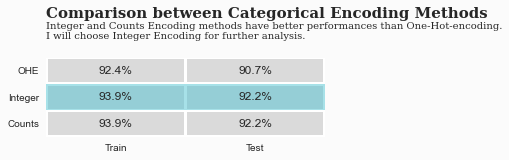

In [70]:
import matplotlib

fig = plt.figure(figsize=(5, 8))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall
#df_models = round(pd.concat([svc_df, dtree_df, rfc_df, tu_rfc_df, log_df, knn_df], axis=1), 3)

sns.heatmap(cat_encoding, cmap=colormap, annot=True, fmt=".1%", linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.5, 'Comparison between Categorical Encoding Methods', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'Integer and Counts Encoding methods have better performances than One-Hot-encoding.\nI will choose Integer Encoding for further analysis.',
        fontfamily='serif', fontsize=10)


from matplotlib.patches import Rectangle
rect = ax0.add_patch(Rectangle((0, 1), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))

plt.show()

#### Conclusion

I performed one-hot-encoding, label encoding and count encoding for cateogrical variables to explore which technique is good for this dataset.

Given the results above, label encoding or count encoding is the best for this. I will use Integer Encoding method in the further analysis. 

### Variable Transformations for Numerical variables

In the previous notebook (Cleaning_EDA_and_Visualization.ipynb), we found that some numerical variables do not have gaussian distributions, so using transformation methods might help improve model performances because it helps improve value spread. 

Based on the previous analysis, there are 5 continuous variables which are skewed distributions: `Credit_Limit`, `Total_Revolving_Bal`, `Avg_Open_To_Buy`, `Total_Trans_Amt`, `Avg_Utilization_Ratio`.

In [72]:
# create skewed variable list
skewed = ['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 
          'Total_Trans_Amt', 'Avg_Utilization_Ratio']

#### yeo-johnson transformation

In [76]:
use_cols = skewed + ['Attrition_Flag']

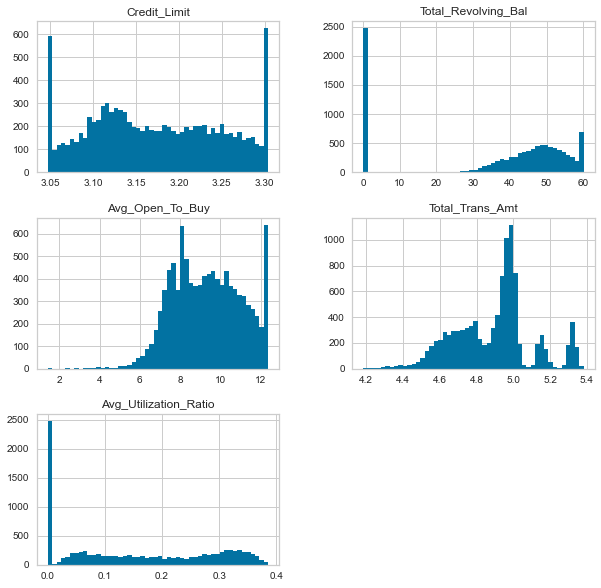

In [83]:
# temporary copy of the data
transformed = df[use_cols]

for var in skewed:
    
    # transform the variable - yeo-johnson
    transformed[var], param = stats.yeojohnson(df[var])
    
# plot the histogram of the transformed variables
transformed[skewed].hist(bins=50, figsize=(10,10))
plt.show()

We can say some variables (credit_limit, and Avg_Open_To_Buy) improved its distribution. To determin if this is the case, we can compare the model performances between original and transformed data. 

In [78]:
# create original data with skewed variables
original = df[use_cols]
original.head(2)

,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Avg_Utilization_Ratio,Attrition_Flag
0,12691.0,777,11914.0,1144,0.061,Existing Customer
1,8256.0,864,7392.0,1291,0.105,Existing Customer


In [79]:
# separate train and test set for original data
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    original.drop(['Attrition_Flag'], axis=1),
    original['Attrition_Flag'],
    test_size=0.2,
    random_state=0)

In [84]:
# separate train and test set for transformed data
X_train_transform, X_test_transform, y_train_transform, y_test_transform = train_test_split(
    transformed.drop(['Attrition_Flag'], axis=1),
    transformed['Attrition_Flag'],
    test_size=0.2,
    random_state=0)

In [85]:
run_RFs(X_train_original, X_test_original, y_train_original, y_test_original)

Train set
Random Forests roc-auc: 0.8980773365172281
Test set
Random Forests roc-auc: 0.8772959534674198


(0.8980773365172281, 0.8772959534674198)

In [86]:
run_RFs(X_train_transform, X_test_transform, y_train_transform, y_test_transform)

Train set
Random Forests roc-auc: 0.8980975826158273
Test set
Random Forests roc-auc: 0.8772959534674198


(0.8980975826158273, 0.8772959534674198)

It shows any improved performance after transforming variables with yeo-johnson

#### log transformation

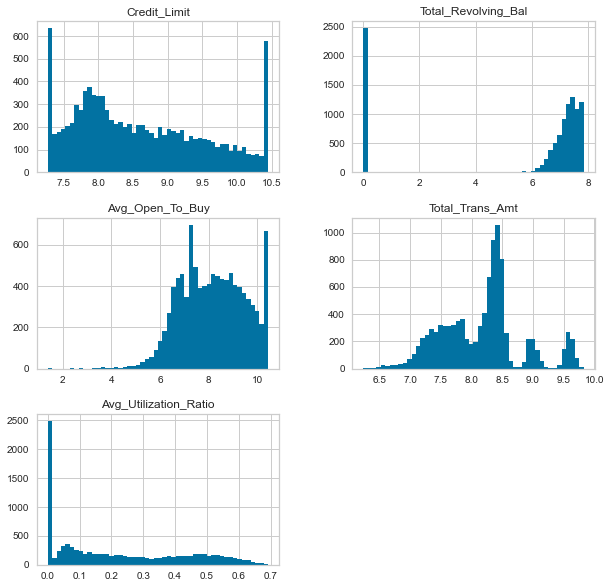

In [87]:
# temporary copy of the data
transformed = df[use_cols]

for var in skewed:
    
    # transform the variable - log
    transformed[var] = np.log1p(transformed[var])
    
# plot the histogram of the transformed variables
transformed[skewed].hist(bins=50, figsize=(10,10))
plt.show()

In [88]:
# separate train and test set for transformed data
X_train_transform, X_test_transform, y_train_transform, y_test_transform = train_test_split(
    transformed.drop(['Attrition_Flag'], axis=1),
    transformed['Attrition_Flag'],
    test_size=0.2,
    random_state=0)

In [89]:
run_RFs(X_train_original, X_test_original, y_train_original, y_test_original)

Train set
Random Forests roc-auc: 0.8980773365172281
Test set
Random Forests roc-auc: 0.8772959534674198


(0.8980773365172281, 0.8772959534674198)

In [90]:
run_RFs(X_train_transform, X_test_transform, y_train_transform, y_test_transform)

Train set
Random Forests roc-auc: 0.8981006027520824
Test set
Random Forests roc-auc: 0.8772959534674198


(0.8981006027520824, 0.8772959534674198)

#### Conclusions

Given the comparison between original dataset and transformed dataset, variable transformations did not improve model performances. Therefore, I would not use transformation methods unless I use linear models. 

### Feature Scaling

Feature scaling is important because similar scales help machine learning models decrease the time to learn data. Also, some machine learning models (e.g. linear models, SVM) are sensitive to the scale of the variable.

I will perform several feature scaling techniques, and explore which feature scaling method is the best for this dataset.



In [93]:
num_vars 

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [94]:
# numeric features and target list
use_cols = num_vars + ['Attrition_Flag']

# copy data
tmp = df[use_cols]
tmp.head(2)

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,Existing Customer
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,Existing Customer


In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    tmp.drop(['Attrition_Flag'], axis=1), #predictors
    tmp['Attrition_Flag'], # target
    test_size=0.2, # the percentage of test size
    random_state=0, # for reproducibility
)

X_train.shape, X_test.shape    

((8101, 14), (2026, 14))

#### Standardization

Standardization involves centering the variable at zero, and standardizing the variance to 1. The procedure involves subtracting the mean of each observation and then dividing by the standard deviation.

The shape of a standardized distribution will be identical to the original distribution of the variable. If the original distribution is normal, then the standardized distribution will be normal. But, if the original distribution is skewed, then the standarized distribution of the varialbe will also be skewed. Thus, standardizing a variable does not normalize the distribution of the data.

In [96]:
# copy dataset
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# set up the scaler
standard_scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
standard_scaler.fit(X_train_stand)

# transform train and test set
X_train_stand = standard_scaler.transform(X_train_stand)
X_test_stand = standard_scaler.transform(X_test_stand)

In [97]:
# transform the returned Numpy arrays to dataframes 
X_train_stand = pd.DataFrame(X_train_stand, columns=X_train.columns)
X_test_stand = pd.DataFrame(X_test_stand, columns=X_test.columns)

#### Mean normalization

Mean normalization involves centering the variable at zero, and re-scaling to the value range. The procedure involves subtracting the mean of each observation and then dividing by difference between the minimum and maximum value.

Like standardization, this technique will not normalize the distribution of the data.

In [98]:
# copy dataset
X_train_mean = X_train.copy()
X_test_mean = X_test.copy()

# set up the StandardScaler so that it removes the mean
# but does not divide by the standard deviation
scaler_mean = StandardScaler(with_mean=True, with_std=False)

# set up the robustscaler so that it does NOT remove the median
# but normalizes by max()-min(), importnat for this to set up
# the quantile range to 0 and 100, which represent the min and max values
scaler_minmax = RobustScaler(with_centering=False,
                            with_scaling=True,
                            quantile_range=(0,100))

# fit the scalers to the train set, it will learn the parameters
scaler_mean.fit(X_train_mean)
scaler_minmax.fit(X_train_mean)

# transform train and test sets
X_train_mean = scaler_minmax.transform(scaler_mean.transform(X_train_mean))
X_test_mean = scaler_minmax.transform(scaler_mean.transform(X_test_mean))

In [99]:
# create dataframe
X_train_mean = pd.DataFrame(X_train_mean, columns=X_train.columns)
X_test_mean = pd.DataFrame(X_test_mean, columns=X_test.columns)

#### MinMaxScaling

Minimum and maximum scaling squeezes the vales between 0 and 1. The result of the transformation is a distribution which values vary within the range of 0 to 1. But the mean is not centered at zero and the standard deviation varies across variables. The shpae of a min-max scaled distribution will be similar to the original variable. This scaling technique is also sensitive to outliers.

In [100]:
# copy dataset
X_train_minmax = X_train.copy()
X_test_minmax = X_test.copy()

# set up scaler
scaler_minmax = MinMaxScaler()


# fit the scalers to the train set, it will learn the parameters
scaler_minmax.fit(X_train_minmax)


# transform train and test sets
X_train_minmax = scaler_minmax.transform(scaler_minmax.transform(X_train_minmax))
X_test_minmax = scaler_minmax.transform(scaler_minmax.transform(X_test_minmax))

In [101]:
# create dataframe

X_train_minmax = pd.DataFrame(X_train_minmax, columns=X_train.columns)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=X_test.columns)

#### MaxAbsScaling

Maximum Absolute Scaling transforms the data to its absolute maximum value. The result is distributed which values vary within the range of -1 to 1. But the mean is not centered as zero and the standard deviation varies across variables.

This may not preserve the shape of the original distribution and it is sensitive outliers.

In [102]:
# copy dataset
X_train_maxabs = X_train.copy()
X_test_maxabs = X_test.copy()

# set up the scale
scaler_maxabs = MaxAbsScaler()

# fit the train set
scaler_maxabs.fit(X_train_maxabs)

# transform
X_train_maxabs = scaler_maxabs.transform(X_train)
X_test_maxabs = scaler_maxabs.transform(X_test)

In [103]:
# create dataframe
X_train_maxabs = pd.DataFrame(X_train_maxabs, columns=X_train.columns)
X_test_maxabs = pd.DataFrame(X_test_maxabs, columns=X_test.columns)

#### RobustScaling

RobustScaling removes the median from the observations and then scaled to the inter-quantile range (IQR). This produces more robust estimates for the center and range of the variable, and is recommended if the data shows outliers (and our dataset has outliers).

It may not preserve the shape of the original distribution, and the minimum and maximum values vary, but is robust outliers.

In [104]:
# copy dataset
X_train_robust = X_train.copy()
X_test_robust = X_test.copy()

# set up the scaler
scaler_robust = RobustScaler()

# fit training set
scaler_robust.fit(X_train_robust)

# transform
X_train_robust = scaler_robust.transform(X_train_robust)
X_test_robust = scaler_robust.transform(X_test_robust)

# save as dataframe
X_train_robust = pd.DataFrame(X_train_robust, columns=X_train.columns)
X_test_robust = pd.DataFrame(X_test_robust, columns=X_test.columns)

#### Evaluate model performances based on different feature scaling methods

In [116]:
feature_scaling = {"Original": run_RFs(X_train, X_test, y_train, y_test),
                   "Standardization": run_RFs(X_train_stand, X_test_stand, y_train, y_test),
                   "MeanNormalization": run_RFs(X_train_mean, X_test_mean, y_train, y_test),
                   "MinMaxScaling": run_RFs(X_train_minmax, X_test_minmax, y_train, y_test),
                   "MaxAbsScaling": run_RFs(X_train_maxabs, X_test_maxabs, y_train, y_test),
                   "RobustScaling": run_RFs(X_train_robust, X_test_robust, y_train, y_test)
                  }

Train set
Random Forests roc-auc: 0.9406386626210265
Test set
Random Forests roc-auc: 0.9238426698180955
Train set
Random Forests roc-auc: 0.9406363136261613
Test set
Random Forests roc-auc: 0.9238332456889321
Train set
Random Forests roc-auc: 0.940634859486483
Test set
Random Forests roc-auc: 0.9238426698180954
Train set
Random Forests roc-auc: 0.9355919590102634
Test set
Random Forests roc-auc: 0.9158293327905035
Train set
Random Forests roc-auc: 0.9406368729106531
Test set
Random Forests roc-auc: 0.9238389001664301
Train set
Random Forests roc-auc: 0.9406360899123646
Test set
Random Forests roc-auc: 0.9238445546439281


In [117]:
feature_scaling = pd.DataFrame(feature_scaling, index=['Train', 'Test']).T

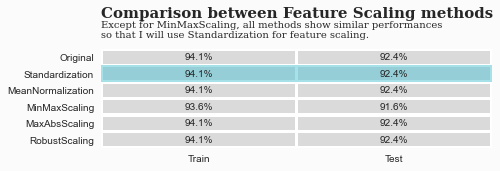

In [130]:
import matplotlib

fig = plt.figure(figsize=(7, 10))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall

sns.heatmap(feature_scaling, cmap=colormap, annot=True, fmt=".1%", linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.9, 'Comparison between Feature Scaling methods', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'Except for MinMaxScaling, all methods show similar performances \nso that I will use Standardization for feature scaling.',
        fontfamily='serif', fontsize=10)


from matplotlib.patches import Rectangle
rect = ax0.add_patch(Rectangle((0, 1), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))

plt.show()

#### Conclusion

I tried to compare several feature scaling methods and 5 methods show similar performances except for MinMaxScaling. 

Therefore, I will use Standardization for feature scaling. 

## Conclusions

In this notebook, we've tried to find the best methods for feature engineering and feature scaling. Since numerical variable transformations did not improve the model performances at all, I won't use it when building models later. 

Based on the results above, I will perform:

- Integer Encoding for categorical variables
- StandardScaler for feature scaling

In the next notebook, I will try some over-sampling methods to improve model performances because we have imbalanced dataset. 